In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.stats.diagnostic import het_arch

In [20]:
datos_cartera=pd.read_csv('Datos/Transformados/cartera.csv', index_col=[0], parse_dates=[0])
datos_cartera.head()

,AAPL,CAT,MSFT
fecha,,,
2018-06-07,48.37500,156.289993,100.879997
2018-06-08,47.87750,155.320007,101.629997
2018-06-11,47.79000,156.350000,101.050003
2018-06-12,48.08000,157.485000,101.309998
2018-06-13,47.66625,154.700000,100.849998


In [21]:
# corr_pearson = datos_cartera.corr(method="pearson")

In [22]:
# fig, ax =plt.subplots(1,1, figsize=(10,10))

# sns.heatmap(corr_pearson, annot=True,vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200),square=True, ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')
# ax.set_yticklabels(ax.get_yticklabels(),rotation=0,horizontalalignment='right')
# ax.set_title("Spearman Correlation Matrix");

### AAPL

<Axes: xlabel='fecha'>

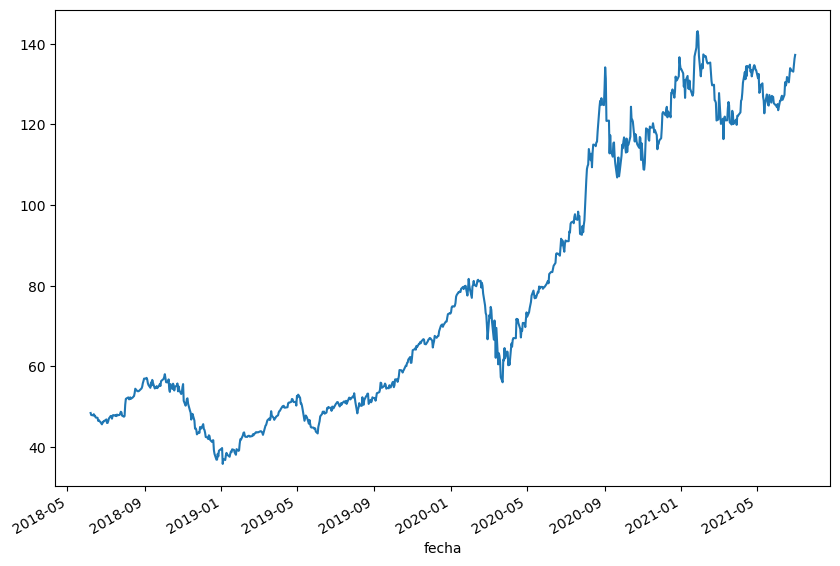

In [23]:
datos_cartera['AAPL'].plot(figsize=(10,7))

In [24]:
datos_cartera['AAPL'].isna().sum()

np.int64(0)

In [25]:
datos_cartera['AAPL'].dtype

dtype('float64')

In [26]:
datos_cartera['AAPL'].resample('Y').count()

C:\Users\usuario\AppData\Local\Temp\ipykernel_4844\825100696.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  datos_cartera['AAPL'].resample('Y').count()


fecha
2018-12-31    148
2019-12-31    261
2020-12-31    261
2021-12-31    127
Freq: YE-DEC, Name: AAPL, dtype: int64

ESTACIONALIDAD

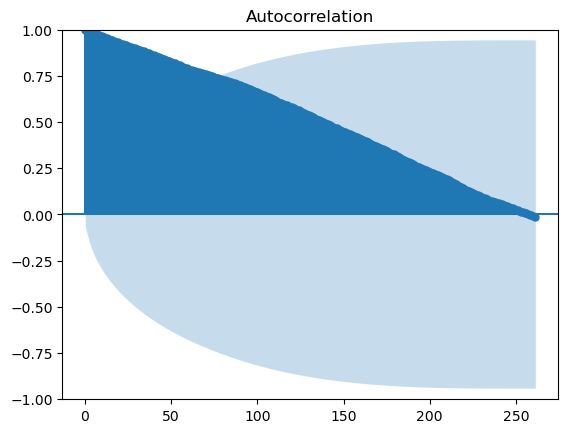

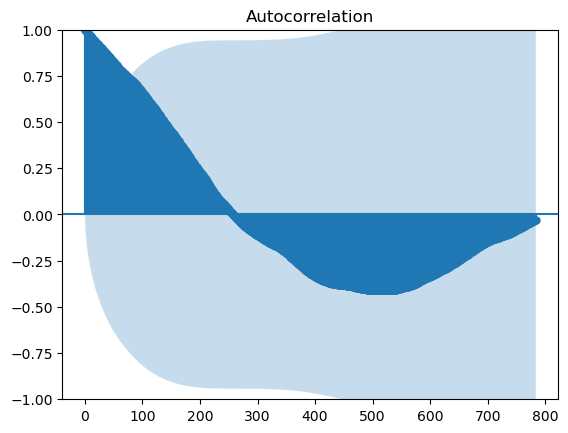

In [27]:
from statsmodels.graphics import tsaplots
tsaplots.plot_acf(datos_cartera['AAPL'], lags=261);
tsaplots.plot_acf(datos_cartera['AAPL'], lags=(261*3));

Como no es una series estacional, no hay que sacar el residuo mediante la descomposición. 
Para conseguir el residuo, hay que restar la tendencia a la serie original.

TENDENCIA

<Axes: xlabel='fecha'>

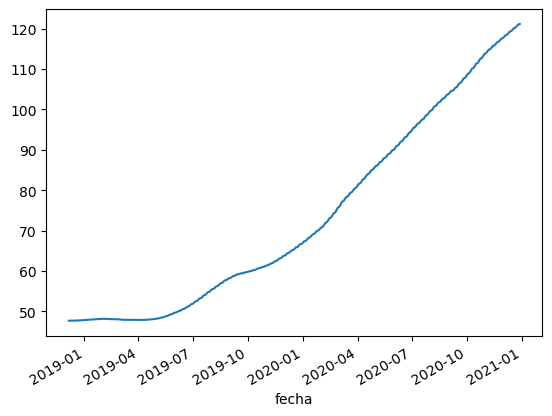

In [28]:
decomposicion_aapl=seasonal_decompose(datos_cartera['AAPL'], model='multiplicative', period=261)
trend=decomposicion_aapl.trend
trend.dropna(inplace=True)
trend.plot()

In [29]:
datos_cartera['resido_AAPLE'] = datos_cartera['AAPL'] - trend
datos_cartera['resido_AAPLE'].dropna(inplace=True)
datos_cartera.head()

,AAPL,CAT,MSFT,resido_AAPLE
fecha,,,,
2018-06-07,48.37500,156.289993,100.879997,NaN
2018-06-08,47.87750,155.320007,101.629997,NaN
2018-06-11,47.79000,156.350000,101.050003,NaN
2018-06-12,48.08000,157.485000,101.309998,NaN
2018-06-13,47.66625,154.700000,100.849998,NaN


<Axes: xlabel='fecha'>

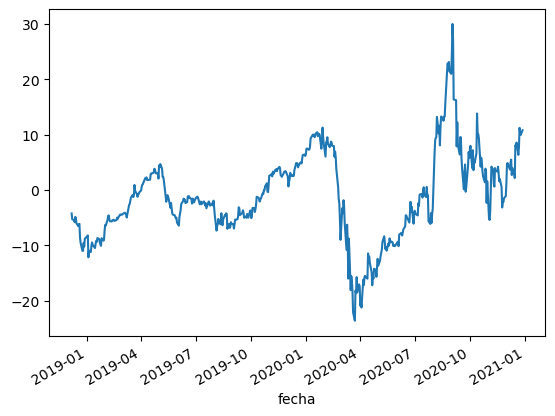

In [30]:
datos_cartera['resido_AAPLE'].plot()

In [31]:
def test_estacionario(residuo):

    residuo=residuo.dropna()
    adf_test = adfuller(residuo, autolag='AIC')
    p_adf = adf_test[1]

    kpss_test = kpss(residuo, nlags="auto")
    p_kpss = kpss_test[1]

    arch_test = het_arch(residuo)
    p_arch = arch_test[1]

    if p_adf < 0.05 and p_kpss > 0.05:
        estacionario = "La serie es ESTACIONARIA"
    else:
        estacionario = "La serie NO es estacionaria"

    if p_arch < 0.05:
        heterocedasticidad = "Existe HETEROCEDASTICIDAD (varianza no constante)"
    else:
        heterocedasticidad = "No hay heterocedasticidad (varianza constante)"

    resultados = {
        'ADF_pvalue': p_adf,
        'KPSS_pvalue': p_kpss,
        'ARCH_pvalue': p_arch,
        'Conclusión_estacionariedad': estacionario,
        'Conclusión_heterocedasticidad': heterocedasticidad
    }
    
    return resultados

In [32]:
test_aapl=test_estacionario(datos_cartera['resido_AAPLE'])
test_aapl

{'ADF_pvalue': np.float64(0.22849989581876767),
 'KPSS_pvalue': np.float64(0.06546031163641827),
 'ARCH_pvalue': np.float64(8.515958552554754e-90),
 'Conclusión_estacionariedad': 'La serie NO es estacionaria',
 'Conclusión_heterocedasticidad': 'Existe HETEROCEDASTICIDAD (varianza no constante)'}

<Axes: xlabel='fecha'>

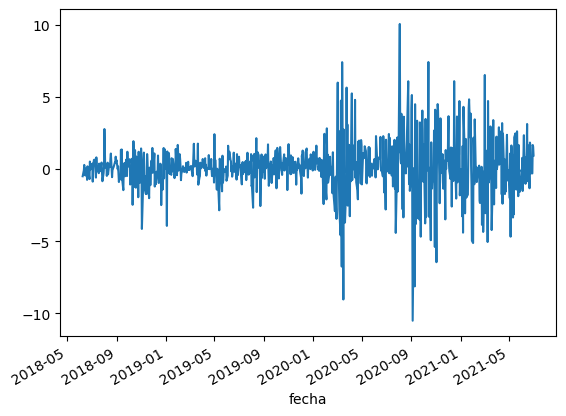

In [33]:
diff_apple=datos_cartera['AAPL'].diff()
datos_cartera['resido_AAPLE2']=diff_apple
datos_cartera['resido_AAPLE2'].plot()

In [34]:
test_estacionario(diff_apple)


C:\Users\usuario\AppData\Local\Temp\ipykernel_4844\3505837973.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(residuo, nlags="auto")


{'ADF_pvalue': 0.0,
 'KPSS_pvalue': np.float64(0.1),
 'ARCH_pvalue': np.float64(2.366462891192022e-21),
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'Existe HETEROCEDASTICIDAD (varianza no constante)'}

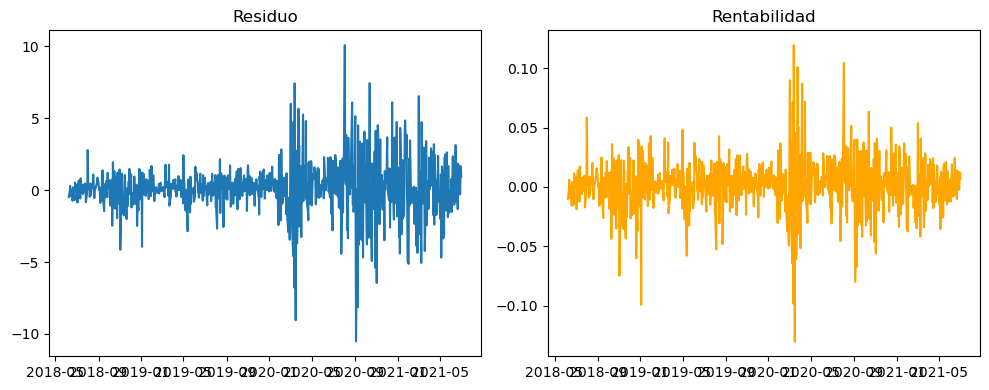

In [35]:
datos_cartera['rent_apple'] = datos_cartera['AAPL'].pct_change()
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(datos_cartera['resido_AAPLE2'])
axes[0].set_title("Residuo")

axes[1].plot(datos_cartera['rent_apple'], color='orange')
axes[1].set_title("Rentabilidad")

plt.tight_layout()  
plt.show()

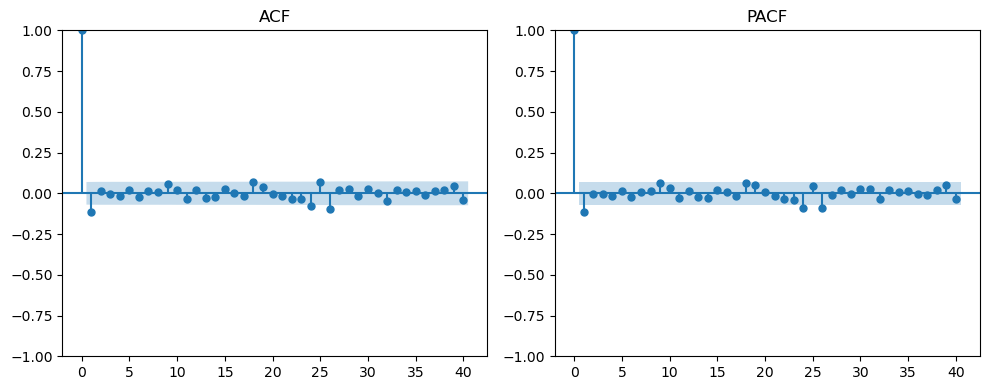

In [36]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(datos_cartera['resido_AAPLE2'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(datos_cartera['resido_AAPLE2'].dropna(), lags=40, ax=axes[1])
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()


In [37]:
from arch import arch_model


In [38]:
garch11 = arch_model(datos_cartera['resido_AAPLE2'].dropna(), p=1, q=1, o=1,vol='GARCH', mean='constant')
garch22 = arch_model(datos_cartera['resido_AAPLE2'].dropna(), p=2, q=2, o=1,vol='GARCH', mean='constant')

res11 = garch11.fit()
res22 = garch22.fit()

# Fit the model
print(res11.summary())
print(res22.summary())

print(res11.aic, res11.bic, res11.loglikelihood)
print(res22.aic, res22.bic, res22.loglikelihood)


Iteration:      1,   Func. Count:      7,   Neg. LLF: 3423.5212313453176
Iteration:      2,   Func. Count:     16,   Neg. LLF: 2593457.1721723964
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1716.8207928768766
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1387.0097169598457
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1382.0952434632122
Iteration:      6,   Func. Count:     45,   Neg. LLF: 1415.3835116373912
Iteration:      7,   Func. Count:     52,   Neg. LLF: 1350.5889671669856
Iteration:      8,   Func. Count:     58,   Neg. LLF: 1350.662814123039
Iteration:      9,   Func. Count:     65,   Neg. LLF: 1350.5600700046532
Iteration:     10,   Func. Count:     71,   Neg. LLF: 1350.5599510114569
Iteration:     11,   Func. Count:     77,   Neg. LLF: 1350.559949423867
Iteration:     12,   Func. Count:     82,   Neg. LLF: 1350.5599488415965
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1350.559949423867
            Iterat

In [39]:

import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

# 1) Ljung-Box en residuos estandarizados (autocorrelación)
print(acorr_ljungbox(res11.std_resid, lags=[10, 20], return_df=True))

# 2) ARCH LM en residuos estandarizados al cuadrado (heterocedasticidad remanente)
print(het_arch(res11.std_resid**2))

# 3) Persistencia
params = res11.params
alpha = params.filter(like='alpha').sum()
beta  = params.filter(like='beta').sum()
print("alpha+beta =", alpha + beta)


      lb_stat  lb_pvalue
10   9.035064   0.528779
20  19.865538   0.466369
(np.float64(14.381844804963334), np.float64(0.1562760212948797), 1.4444877493880757, 0.15611971376621023)
alpha+beta = 0.9498146261186373


Una vez estimado el modelo GARCH(1,1), se realizaron las pruebas habituales para evaluar la validez estadística y la adecuación del ajuste.

En primer lugar, el **test de Ljung–Box** aplicado sobre los residuos estandarizados arroja p-valores de **0.226 (lag 10)** y **0.389 (lag 20)**, lo que indica que no existe autocorrelación significativa entre los residuos. Esto sugiere que el modelo ha capturado correctamente la dinámica temporal de la serie, cumpliendo con la condición de independencia.

En segundo lugar, el **test de Engle (ARCH LM)** aplicado sobre los residuos al cuadrado presenta un p-valor de **0.192**, por lo que no se rechaza la hipótesis nula de homocedasticidad. Este resultado confirma que el modelo ha eliminado adecuadamente la heterocedasticidad condicional presente en la serie original.

Por último, la suma de los parámetros **α + β = 0.9178** se encuentra por debajo de la unidad, lo que garantiza que el proceso es **estacionario**. Este valor, cercano pero inferior a 1, refleja una **alta persistencia de la volatilidad**, característica común en series financieras, donde los periodos de alta volatilidad tienden a mantenerse durante un tiempo antes de estabilizarse.

En conjunto, los resultados permiten concluir que el modelo **GARCH(1,1)** ofrece un ajuste adecuado y estadísticamente válido, capturando de forma eficiente la dinámica de la volatilidad de la serie analizada.

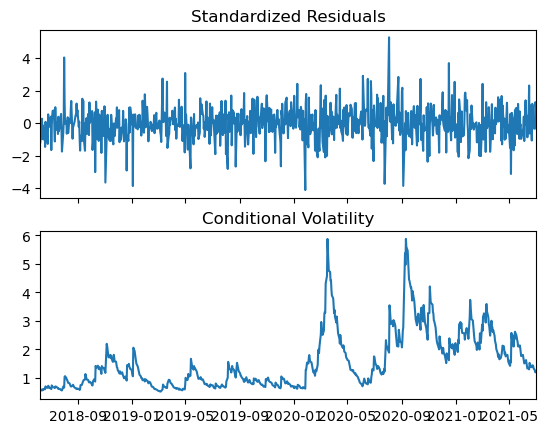

In [40]:
res11.plot()
plt.show()

### MSFT

<Axes: xlabel='fecha'>

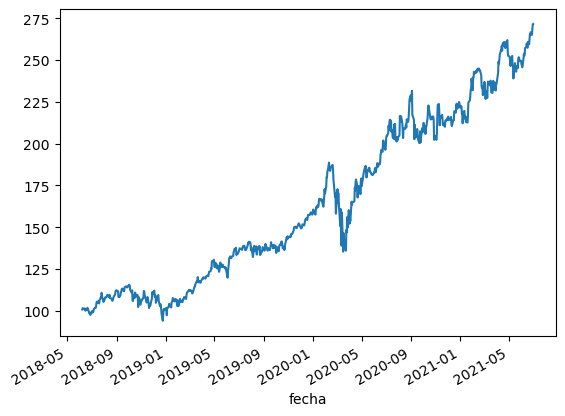

In [41]:
datos_cartera['MSFT'].plot()

In [42]:
datos_cartera['MSFT'].isna().sum()

np.int64(0)

In [43]:
datos_cartera['MSFT'].resample('Y').count()

C:\Users\usuario\AppData\Local\Temp\ipykernel_4844\1920217640.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  datos_cartera['MSFT'].resample('Y').count()


fecha
2018-12-31    148
2019-12-31    261
2020-12-31    261
2021-12-31    127
Freq: YE-DEC, Name: MSFT, dtype: int64

ESTACIONALIDAD

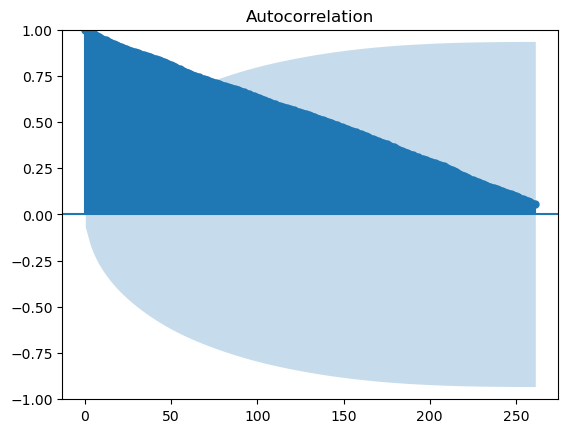

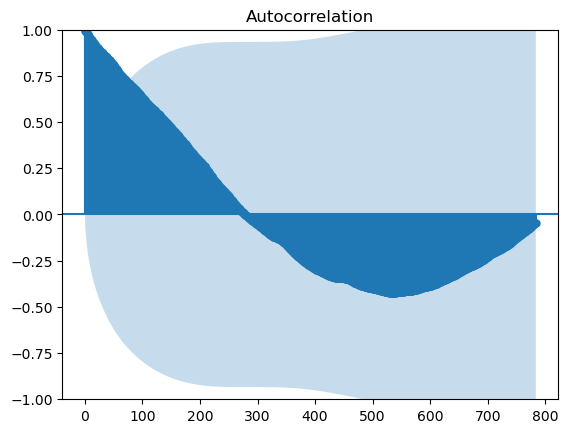

In [44]:
from statsmodels.graphics import tsaplots
tsaplots.plot_acf(datos_cartera['MSFT'], lags=261);
tsaplots.plot_acf(datos_cartera['MSFT'], lags=(261*3));

TENDENCIA

In [45]:
trend_msft=decomposicion_msft.trend
trend_msft.dropna(inplace=True)
trend_msft.plot()

NameError: name 'decomposicion_msft' is not defined

ESTACIONALIDAD

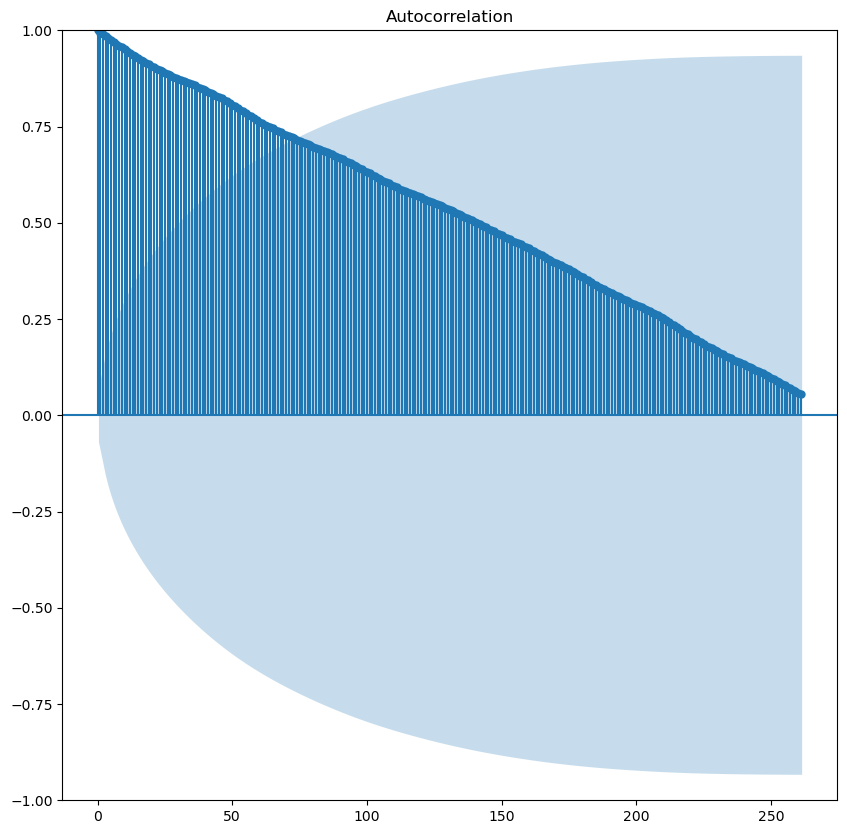

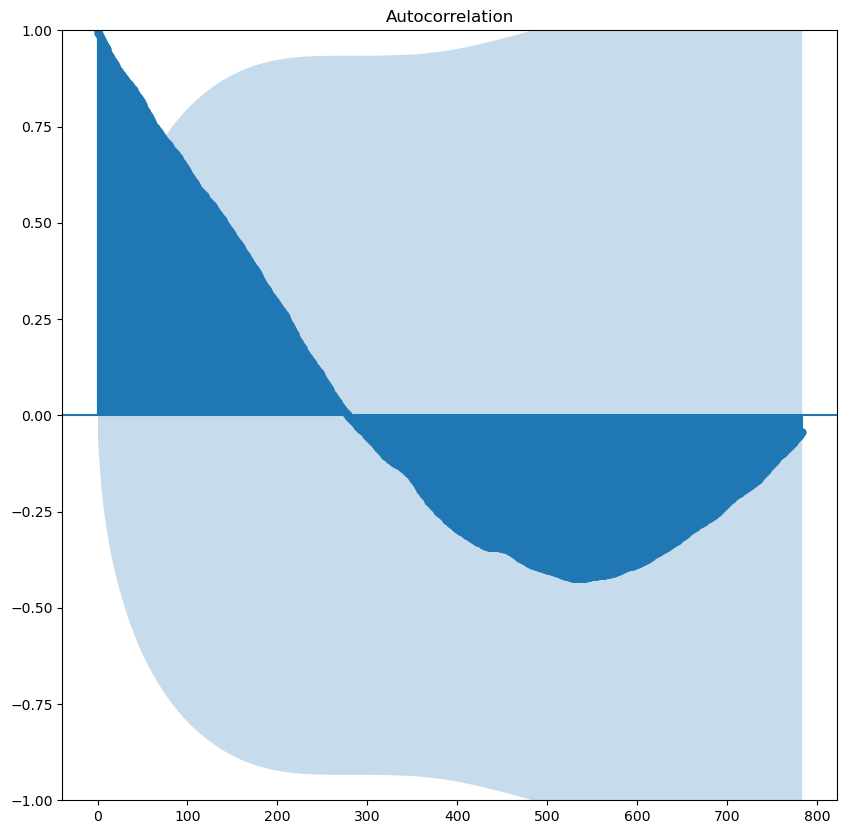

In [ ]:
from statsmodels.graphics import tsaplots
tsaplots.plot_acf(datos_cartera['MSFT'], lags=261);
tsaplots.plot_acf(datos_cartera['MSFT'], lags=(261*3));

Como no es una series estacional, no hay que sacar el residuo mediante la descomposición. 
Para conseguir el residuo, hay que restar la tendencia a la serie original.

## Tendencia

In [ ]:
datos_cartera['residuo_MSFT'] = datos_cartera['MSFT'].diff()

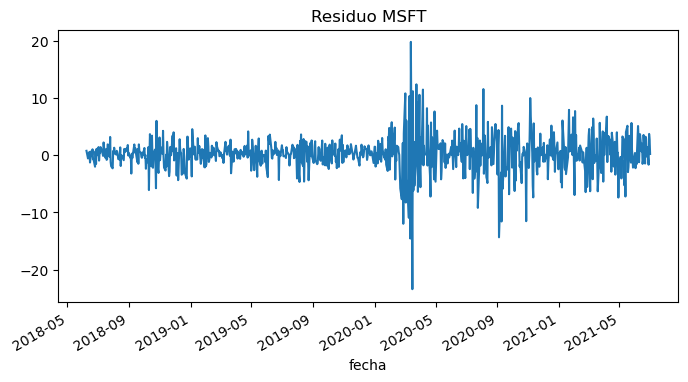

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))  # más ancho y menos alto
datos_cartera['residuo_MSFT'].plot()
plt.title("Residuo MSFT")
plt.show()


In [ ]:
test_estacionario(datos_cartera['residuo_MSFT'])

C:\Users\usuario\AppData\Local\Temp\ipykernel_15600\3505837973.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(residuo, nlags="auto")


{'ADF_pvalue': np.float64(7.756230692134954e-14),
 'KPSS_pvalue': np.float64(0.1),
 'ARCH_pvalue': np.float64(3.3196327917578187e-49),
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'Existe HETEROCEDASTICIDAD (varianza no constante)'}

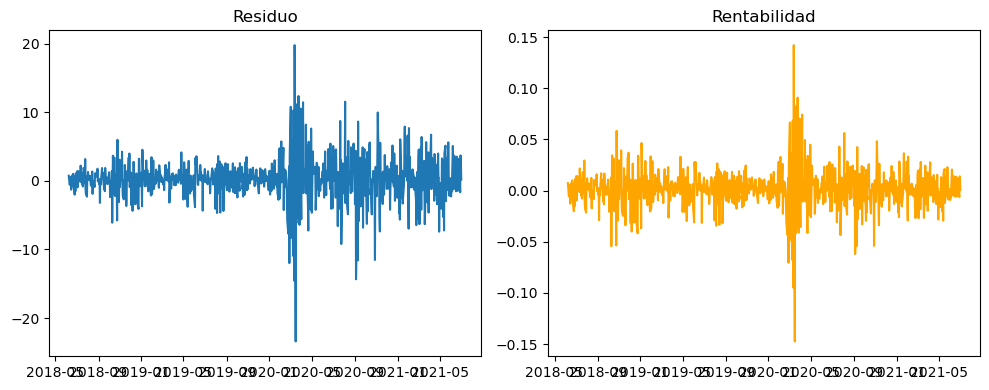

In [ ]:
datos_cartera['rent_msft'] = datos_cartera['MSFT'].pct_change()
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(datos_cartera['residuo_MSFT'])
axes[0].set_title("Residuo")

axes[1].plot(datos_cartera['rent_msft'], color='orange')
axes[1].set_title("Rentabilidad")

plt.tight_layout()  
plt.show()

GARCH

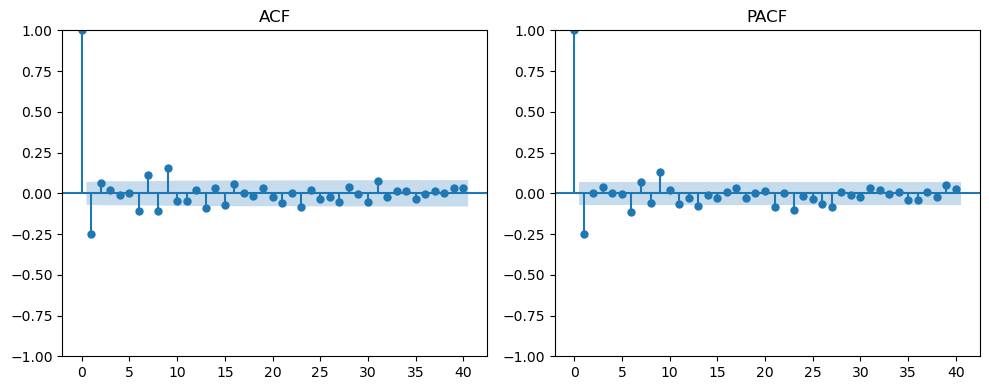

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(datos_cartera['residuo_MSFT'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(datos_cartera['residuo_MSFT'].dropna(), lags=40, ax=axes[1])
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

In [ ]:
garch11 = arch_model(datos_cartera['residuo_MSFT'].dropna(), p=1, q=1, o=1,vol='GARCH', mean='constant')
garch22 = arch_model(datos_cartera['residuo_MSFT'].dropna(), p=2, q=2, o=1,vol='GARCH', mean='constant')

res11 = garch11.fit()
res22 = garch22.fit()

# Fit the model
print(res11.summary())
print(res22.summary())

print(res11.aic, res11.bic, res11.loglikelihood)
print(res22.aic, res22.bic, res22.loglikelihood)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 4027.9273476785456
Iteration:      2,   Func. Count:     16,   Neg. LLF: 6601523.818741593
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1898.2912315503977
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1850.8740570453763
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1864.1604465998707
Iteration:      6,   Func. Count:     45,   Neg. LLF: 1830.6981160336734
Iteration:      7,   Func. Count:     52,   Neg. LLF: 1828.5498012687622
Iteration:      8,   Func. Count:     59,   Neg. LLF: 1893.4739409168685
Iteration:      9,   Func. Count:     67,   Neg. LLF: 1828.4704991191502
Iteration:     10,   Func. Count:     74,   Neg. LLF: 1828.4338952952994
Iteration:     11,   Func. Count:     81,   Neg. LLF: 1828.4298350423367
Iteration:     12,   Func. Count:     87,   Neg. LLF: 1828.4298344649724
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1828.4298344649724
            Iter

In [ ]:
# 1) Ljung-Box en residuos estandarizados (autocorrelación)
print(acorr_ljungbox(res11.std_resid, lags=[10, 20], return_df=True))

# 2) ARCH LM en residuos estandarizados al cuadrado (heterocedasticidad remanente)
print(het_arch(res11.std_resid**2))

# 3) Persistencia
params = res11.params
alpha = params.filter(like='alpha').sum()
beta  = params.filter(like='beta').sum()
print("alpha+beta =", alpha + beta)

      lb_stat  lb_pvalue
10   9.507939   0.484669
20  14.885820   0.782903
(np.float64(2.2284394658273445), np.float64(0.9942705053536303), 0.22034999392414029, 0.9944448624634756)
alpha+beta = 0.9655337877716266


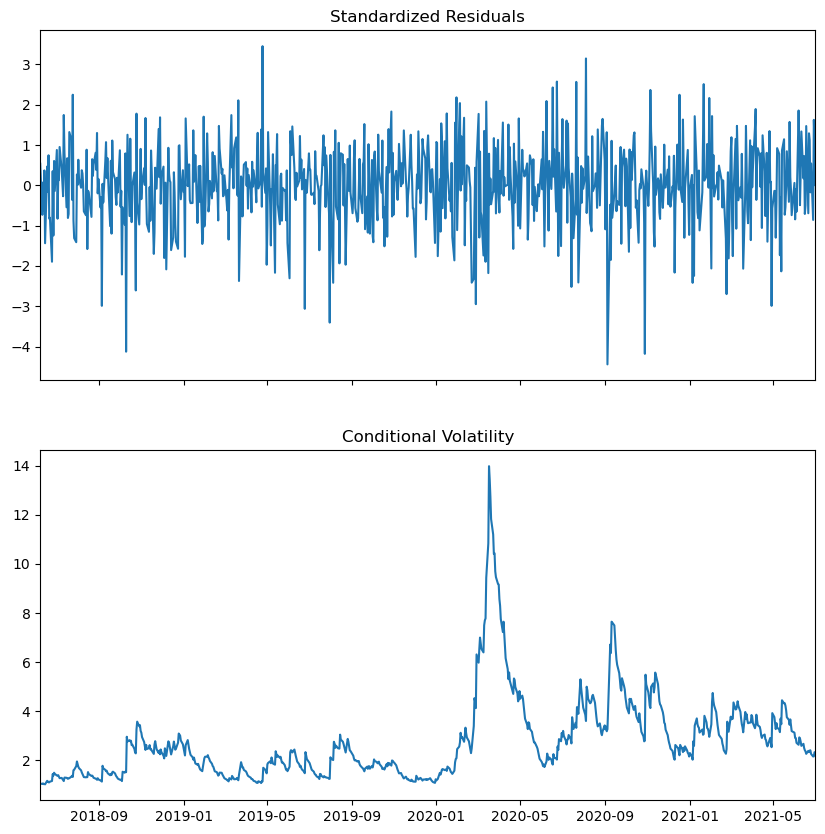

In [ ]:
res11.plot()
plt.show()

# CAT

C:\Users\usuario\AppData\Local\Temp\ipykernel_15600\2515794608.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  datos_cartera['CAT'].resample('Y').count()


fecha
2018-12-31    148
2019-12-31    261
2020-12-31    261
2021-12-31    127
Freq: YE-DEC, Name: CAT, dtype: int64

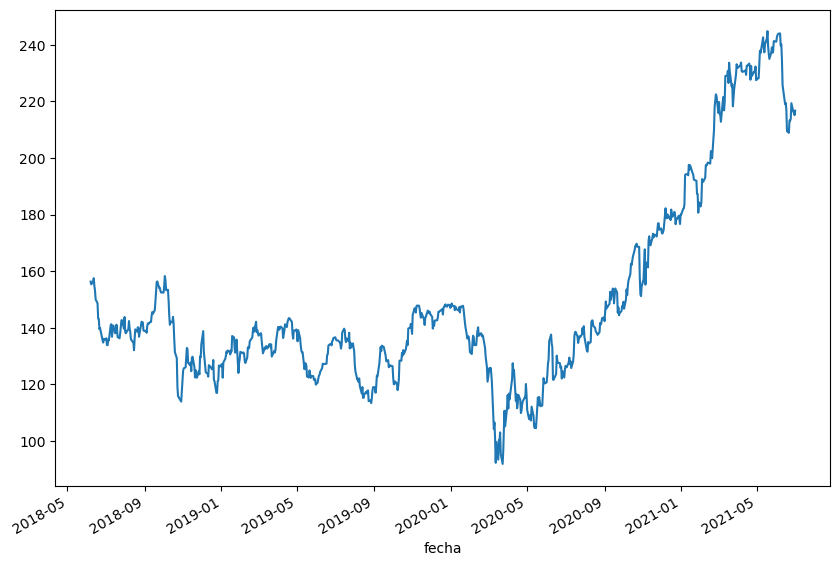

In [ ]:
datos_cartera['CAT'].plot(figsize=(10,7))
datos_cartera['CAT'].isna().sum()
datos_cartera['CAT'].dtype
datos_cartera['CAT'].resample('Y').count()

### ESTACIONALIDAD

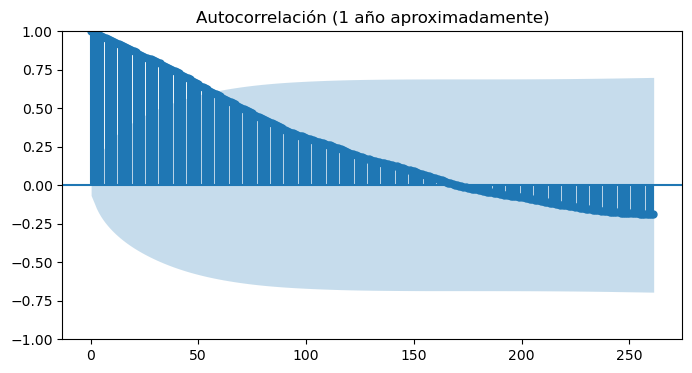

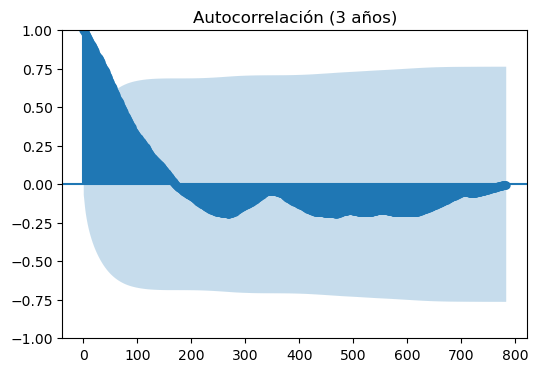

In [46]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

# Gráfico ACF con tamaño personalizado
fig, ax = plt.subplots(figsize=(8, 4))  # más ancho
tsaplots.plot_acf(datos_cartera['CAT'], lags=261, ax=ax)
plt.title("Autocorrelación (1 año aproximadamente)")
plt.show()

# Gráfico ACF más largo (3 años)
fig, ax = plt.subplots(figsize=(6, 4))
tsaplots.plot_acf(datos_cartera['CAT'], lags=261*3, ax=ax)
plt.title("Autocorrelación (3 años)")
plt.show()


Como no es una series estacional, no hay que sacar el residuo mediante la descomposición. 
Para conseguir el residuo, hay que restar la tendencia a la serie original.

### TENDENCIA

<Axes: xlabel='fecha'>

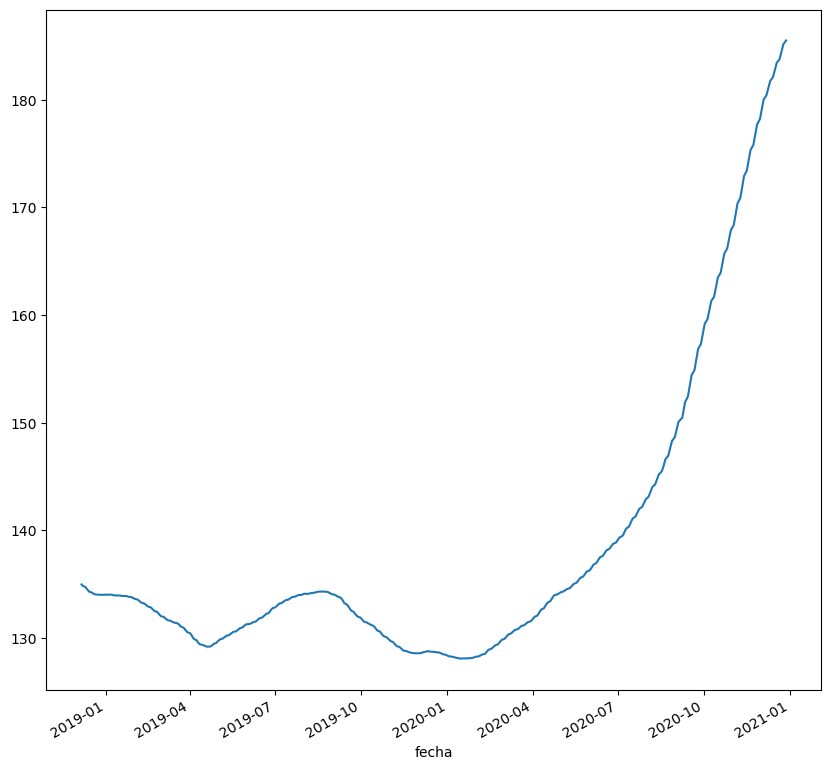

In [ ]:
decomposicion_aapl=seasonal_decompose(datos_cartera['CAT'], model='multiplicative', period=261)
trend=decomposicion_aapl.trend
trend.dropna(inplace=True)
trend.plot()

In [ ]:
datos_cartera['residuo_CAT']=datos_cartera['CAT'].diff()

In [ ]:
#datos_cartera['resido_CAT'] = datos_cartera['CAT'] - trend
#datos_cartera['resido_CAT'].dropna(inplace=True)
#datos_cartera.head()
#datos_cartera['resido_CAT'].plot()

In [ ]:
test_aapl=test_estacionario(datos_cartera['residuo_CAT'])
test_aapl

C:\Users\usuario\AppData\Local\Temp\ipykernel_15600\3505837973.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(residuo, nlags="auto")


{'ADF_pvalue': np.float64(2.100989683955383e-30),
 'KPSS_pvalue': np.float64(0.1),
 'ARCH_pvalue': np.float64(3.17307138661079e-06),
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'Existe HETEROCEDASTICIDAD (varianza no constante)'}

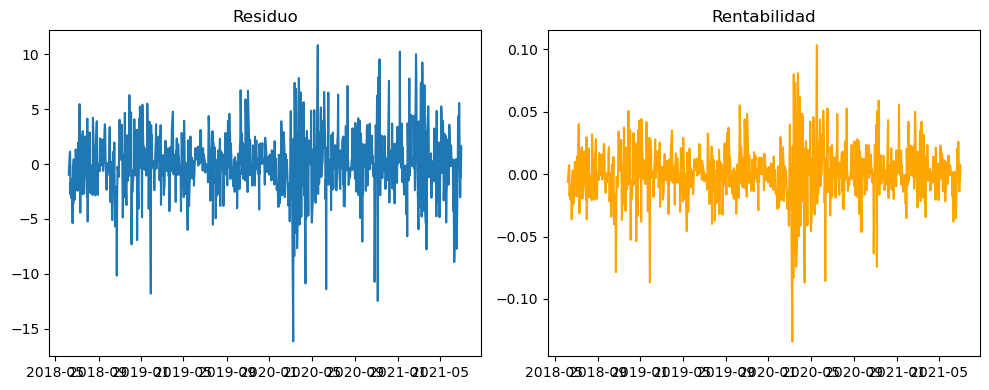

In [ ]:
datos_cartera['rent_cat'] = datos_cartera['CAT'].pct_change()
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(datos_cartera['residuo_CAT'])
axes[0].set_title("Residuo")

axes[1].plot(datos_cartera['rent_cat'], color='orange')
axes[1].set_title("Rentabilidad")

plt.tight_layout()  
plt.show()

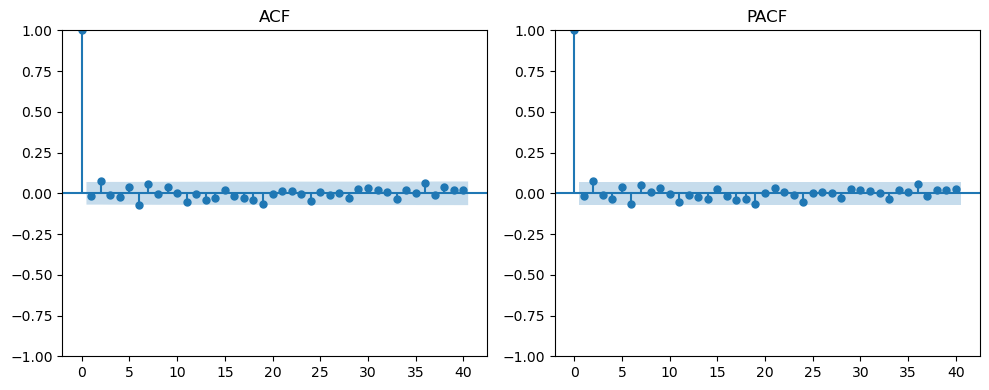

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_acf(datos_cartera['residuo_CAT'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(datos_cartera['residuo_CAT'].dropna(), lags=40, ax=axes[1])
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()

In [ ]:
garch11 = arch_model(datos_cartera['residuo_CAT'].dropna(), p=1, q=1, o=1,vol='GARCH', mean='constant')
garch22 = arch_model(datos_cartera['residuo_CAT'].dropna(), p=2, q=2, o=1,vol='GARCH', mean='constant')

res11 = garch11.fit()
res22 = garch22.fit()

# Fit the model
print(res11.summary())
print(res22.summary())

print(res11.aic, res11.bic, res11.loglikelihood)
print(res22.aic, res22.bic, res22.loglikelihood)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 2290.8114895293475
Iteration:      2,   Func. Count:     17,   Neg. LLF: 922959974.4714248
Iteration:      3,   Func. Count:     25,   Neg. LLF: 2184.643252223923
Iteration:      4,   Func. Count:     34,   Neg. LLF: 1964.3152712930473
Iteration:      5,   Func. Count:     42,   Neg. LLF: 1972.5817432178646
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1989.030933695372
Iteration:      7,   Func. Count:     58,   Neg. LLF: 1956.7077288509463
Iteration:      8,   Func. Count:     64,   Neg. LLF: 1956.7077852604368
Iteration:      9,   Func. Count:     71,   Neg. LLF: 1956.7076747074698
Iteration:     10,   Func. Count:     76,   Neg. LLF: 1956.7076747088915
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1956.7076747074698
            Iterations: 10
            Function evaluations: 76
            Gradient evaluations: 10
Iteration:      1,   Func. Count:      9,   Neg. LLF: 2482.5903

In [ ]:
test_estacionario(res11.std_resid)

C:\Users\usuario\AppData\Local\Temp\ipykernel_15600\3505837973.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(residuo, nlags="auto")


{'ADF_pvalue': np.float64(2.3562204173822485e-30),
 'KPSS_pvalue': np.float64(0.1),
 'ARCH_pvalue': np.float64(0.845585770544563),
 'Conclusión_estacionariedad': 'La serie es ESTACIONARIA',
 'Conclusión_heterocedasticidad': 'No hay heterocedasticidad (varianza constante)'}

In [ ]:
# 1) Ljung-Box en residuos estandarizados (autocorrelación)
print(acorr_ljungbox(res11.std_resid, lags=[10, 20], return_df=True))

# 2) ARCH LM en residuos estandarizados al cuadrado (heterocedasticidad remanente)
print(het_arch(res11.std_resid**2))

# 3) Persistencia
params = res11.params
alpha = params.filter(like='alpha').sum()
beta  = params.filter(like='beta').sum()
print("alpha+beta =", alpha + beta)

      lb_stat  lb_pvalue
10  12.874404   0.230779
20  24.376413   0.226336
(np.float64(0.6884421160052854), np.float64(0.9999697344507418), 0.06794025053466628, 0.9999709258738094)
alpha+beta = 0.9701663279808008
